Целью данного эксперимента является нахождение позы нового изображения на основе уже имеющейся реконструкции SfM. Здесь описан пайплайн, когда мы сами создаем SfM при помощи аппрата PixSfM. Вы можете также использовать уже готовую SfM.

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, read_points3D_binary,\
        write_points3D_binary, write_images_binary, read_images_binary, write_images_text, read_cameras_binary, \
        Camera, write_cameras_text, read_cameras_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

**images_all** - путь к папке со всеми изображениями

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после  dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

**pairs-loc.txt** - файл с названиями пар изображений на каждой строке (только на этот раз идут пары для картинок из ДБ со всеми возможными картинками из папки query)

In [8]:
root = Path('/workspace')

images_init = root / f'pokrov_22/colmap_leica/sparse_new/images_renamed.txt'

cameras_init = root / 'pokrov_22/colmap_leica/sparse_new/cameras.txt'
gt_init = root / f'pokrov_22/colmap_leica/sparse_new/points3D.ply'

# all images for our object
images_all = root / f'pixel-perfect-sfm/datasets/leica_loc/'

object_name = 'leica'

# where all result data will be stored
outputs = root / (f'pixel-perfect-sfm/outputs/{object_name}/localization')
# !rm -rf $outputs
outputs.mkdir(parents=True, exist_ok=True)

cache_path = outputs / 's2dnet_featuremaps_sparse.h5'

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
loc_pairs = outputs / 'pairs-loc.txt'

exp1_dir_single_cam = outputs / "ref_exp1_single_cam"
exp1_dir_single_cam.mkdir(parents=True, exist_ok=True)

# 3D mapping and refinement

Здесь описаны возможности для настройки [**extract_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/extract_features.py#L21)

Здесь описаны возможности для настройки [**match_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/match_features.py#L17)

Здесь описан пайплайн того, как можно использовать свои кастомные [**local features**, **matcher**, **image retrieval**](https://github.com/cvg/Hierarchical-Localization/tree/91f40bfd765add3b59ba7376f8579d8829f7fa78#using-your-own-local-features-or-matcher).


In [9]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Create db and query images

Создаем две папки: mapping и query. В папке mapping будут лежать все те картинки, которые нужны нам для построения реконструкции.  В папке query будут находиться все те картинки, для которых мы хотим новую позы.

In [10]:
images = root / f'pixel-perfect-sfm/dataset/{object_name}_loc'
images_references = root / f'pixel-perfect-sfm/datasets/{object_name}_loc/mapping'
images_references.mkdir(parents=True, exist_ok=True)
print(images_references)
ref_num = 287

images_queries = root / f'pixel-perfect-sfm/datasets/{object_name}_loc/query'
images_queries.mkdir(parents=True, exist_ok=True)

/workspace/pixel-perfect-sfm/datasets/leica_loc/mapping


Здесь мы проверяем какие изображения мы будем использовать для построения реконструкции SfM.

In [11]:
references = ['mapping/' + str(p.relative_to(images_references)) for p in images_references.iterdir()]
print(references)
print(len(references), "mapping images")
plot_images([read_image(images_all / r) for r in references[:4]], dpi=50)

[]
0 mapping images


ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x225 with 0 Axes>

**extract_features** - данная функция получает на вход *feature_conf*, *images* (путь к папке с изображениями), *image_list* (список тех изображений, которые вы хотите использовать для feature exctraction), *feature_path* (путь к файлу, где будет сохранен результат). На выходе получаем файл (**features**) с извлеченными features. Если **features** существует, то пропускается.

**pairs_from_exhaustive** - данная функция получает на вход *sfm_pairs* (путь к файлу, где будет сохранен результат), *image_list* (список тех изображений, при помощи которых вы сделаете exhaustive pairs.) На выходе получаем файл (**sfm_pairs**) с парами изображений.  Если **sfm_pairs** существует, то пропускается.

**match_features** - данная функция получает на вход *matcher_conf*, *sfm_pairs* (путь к файлу, где хранятся пары изображений после exhaustive pairing), *features* (путь к файлу, где хранятся извлеченный features для каждого изображения), *matches* (путь к файлу, где хранятся matches для каждой пары изображения). На выходе получаем файл (**matches**) с matches для каждой пары изображений . Если **match_features** существует, то пропускается.


In [8]:
extract_features.main(feature_conf, 
                      images_all, 
                      image_list=references, 
                      feature_path=features)

pairs_from_exhaustive.main(sfm_pairs, 
                           image_list=references)

match_features.main(matcher_conf, 
                    sfm_pairs, 
                    features=features, 
                    matches=matches);

[2022/10/06 21:29:47 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/06 21:29:54 hloc INFO] Finished exporting features.
[2022/10/06 21:29:54 hloc INFO] Found 3 pairs.
[2022/10/06 21:29:54 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/06 21:29:55 hloc INFO] Finished exporting matches.


После того как мы получили features и matches для картинок из папки mapping, мы можем приступить к построению реконструкции при помощи PixSfM. 

Здесь описано как можно настроить конфигурацию для КА и ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [9]:
# run pixsfm

conf = {
        "dense_features": {
                "use_cache": False,
        },
         "KA": {
                "dense_features": {'use_cache': True}, 
                "split_in_subproblems": True,
                "max_kps_per_problem": 1000,  
            },
        
        "BA": { 
                "apply": True,
                "optimizer": {
                      "refine_focal_length": False,  # whether to optimize the focal length
                      "refine_principal_point": False,  # whether to optimize the principal points
                      "refine_extra_params": False,  # whether to optimize distortion parameters
                      "refine_extrinsics": True,  # whether to optimize the camera poses
                }
            }
}


_cams = read_cameras_text(str(cameras_init))
f, cx, cy, k = _cams[0].params

opts = dict(camera_model='PINHOLE', 
            camera_params=','.join(map(str, (f, cx, cy, k))))

hloc_args = dict(
                camera_mode=pycolmap.CameraMode.SINGLE,
                verbose=True,
                image_options=opts)
print(hloc_args)


sfm = PixSfM(conf)
model, sfm_outputs = sfm.reconstruction(exp_loc, 
                                          images_all, 
                                          sfm_pairs, 
                                          features, 
                                          matches, 
                                          image_list=references, 
                                          **hloc_args)

print(model.summary())

{'camera_mode': <CameraMode.SINGLE: 1>, 'verbose': True, 'image_options': {'camera_model': 'PINHOLE', 'camera_params': '2316.555912757072,2318.7800234761503,1178.683483311831,978.7582365226921'}}


[2022/10/06 21:29:58 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/06 21:29:58 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}
[2022/10/06 21:29:58 pixsfm INFO] Building matching graph...
[2022/10/06 21:29:58 pixsfm INFO] Extracting dense features...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/06 21:29:59 pixsfm INFO] Computing tracks...
[2022/10/06 21:29:59 pixsfm INFO] # graph nodes: 1394
[2022/10/06 21:29:59 pixsfm INFO] # graph edges: 1217
[2022/10/06 21:29:59 pixsfm INFO] # tracks: 523
[2022/10/06 21:29:59 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 1394/1394 [00:00, 1955.11it/s]


[2022/10/06 21:30:00 pixsfm INFO] KA Time: 0.712979s, cost change: 0.0214498 --> 0.0157947


[2022/10/06 21:30:00 hloc INFO] Creating an empty database...
[2022/10/06 21:30:01 hloc INFO] Importing images into the database...
[2022/10/06 21:30:02 hloc INFO] Importing features into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/06 21:30:02 hloc INFO] Importing matches into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/06 21:30:02 hloc INFO] Performing geometric verification of the matches...



Custom feature matching

Matching block [1/1] in 0.080s
Elapsed time: 0.002 [minutes]


[2022/10/06 21:30:02 hloc INFO] Running 3D reconstruction...



Loading database

Loading cameras... 1 in 0.001s
Loading matches... 3 in 0.001s
Loading images... 3 in 0.001s (connected 3)
Building correspondence graph... in 0.001s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Finding good initial image pair

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Finding good initial image pair


Initializing with image pair #1 and #3


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.364511e+01    0.00e+00    4.70e+03   0.00e+00   0.00e+00  1.00e+04        0    1.18e-03    3.29e-03
   1  8.876672e+01    4.88e+00    3.42e+02   3.50e+00   9.99e-01  3.00e+04        1    2.37e-03    6.91e-03
   2  8.849498e+01    2.72e-01    1.79e+02   6.51e+00   1.01e+00  9.00e+04        1    2.15e-03    1.01e-02
   3  8.847306e+

  61  8.842012e+01    4.94e-04    1.57e+01   2.72e+00   6.18e-01  1.75e+06        1    2.15e-03    1.89e-01
  62  8.841964e+01    4.80e-04    1.54e+01   2.69e+00   6.19e-01  1.78e+06        1    2.15e-03    1.93e-01
  63  8.841917e+01    4.66e-04    1.52e+01   2.67e+00   6.20e-01  1.80e+06        1    2.18e-03    1.96e-01
  64  8.841872e+01    4.53e-04    1.49e+01   2.65e+00   6.21e-01  1.83e+06        1    2.14e-03    1.99e-01
  65  8.841828e+01    4.39e-04    1.46e+01   2.63e+00   6.21e-01  1.85e+06        1    2.14e-03    2.02e-01
  66  8.841785e+01    4.26e-04    1.44e+01   2.60e+00   6.22e-01  1.88e+06        1    2.16e-03    2.05e-01
  67  8.841744e+01    4.12e-04    1.41e+01   2.58e+00   6.23e-01  1.91e+06        1    2.12e-03    2.08e-01
  68  8.841704e+01    3.99e-04    1.38e+01   2.56e+00   6.24e-01  1.94e+06        1    2.19e-03    2.11e-01
  69  8.841666e+01    3.86e-04    1.36e+01   2.53e+00   6.24e-01  1.97e+06        1    2.16e-03    2.14e-01
  70  8.841628e+01    3.74e-

  17  2.089499e+02    2.59e-02    1.71e+01   6.97e+00   6.54e-01  3.49e+05        1    2.29e-03    6.21e-02
  18  2.089258e+02    2.42e-02    1.66e+01   6.82e+00   6.56e-01  3.60e+05        1    2.27e-03    6.51e-02
  19  2.089033e+02    2.25e-02    1.60e+01   6.68e+00   6.59e-01  3.72e+05        1    2.27e-03    6.81e-02
  20  2.088824e+02    2.09e-02    1.55e+01   6.53e+00   6.61e-01  3.85e+05        1    2.37e-03    7.12e-02
  21  2.088631e+02    1.94e-02    1.49e+01   6.38e+00   6.64e-01  3.99e+05        1    2.29e-03    7.42e-02
  22  2.088452e+02    1.79e-02    1.43e+01   6.22e+00   6.67e-01  4.14e+05        1    2.36e-03    7.73e-02
  23  2.088287e+02    1.65e-02    1.38e+01   6.07e+00   6.70e-01  4.31e+05        1    2.28e-03    8.03e-02
  24  2.088136e+02    1.51e-02    1.32e+01   5.91e+00   6.72e-01  4.50e+05        1    2.29e-03    8.33e-02
  25  2.087998e+02    1.38e-02    1.26e+01   5.75e+00   6.75e-01  4.70e+05        1    2.29e-03    8.63e-02
  26  2.087872e+02    1.26e-

  93  2.086896e+02    2.64e-04    8.52e+00   3.03e+00   5.47e-01  2.28e+06        1    2.36e-03    3.09e-01
  94  2.086894e+02    2.63e-04    8.50e+00   3.03e+00   5.48e-01  2.28e+06        1    2.28e-03    3.12e-01
  95  2.086891e+02    2.61e-04    8.47e+00   3.03e+00   5.48e-01  2.28e+06        1    3.23e-03    3.16e-01
  96  2.086889e+02    2.60e-04    8.44e+00   3.02e+00   5.49e-01  2.28e+06        1    2.29e-03    3.19e-01
  97  2.086886e+02    2.58e-04    8.42e+00   3.02e+00   5.50e-01  2.29e+06        1    2.29e-03    3.22e-01
  98  2.086883e+02    2.57e-04    8.39e+00   3.02e+00   5.51e-01  2.29e+06        1    2.27e-03    3.25e-01
  99  2.086881e+02    2.56e-04    8.37e+00   3.02e+00   5.51e-01  2.29e+06        1    2.27e-03    3.28e-01
 100  2.086878e+02    2.54e-04    8.35e+00   3.01e+00   5.52e-01  2.29e+06        1    2.29e-03    3.31e-01


Bundle adjustment report
------------------------
    Residuals : 2216
   Parameters : 1171
   Iterations : 101
         Time : 0.3317

[2022/10/06 21:30:04 hloc INFO] Reconstructed 1 model(s).
[2022/10/06 21:30:04 hloc INFO] Largest model is #0 with 3 images.
[2022/10/06 21:30:04 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 386
	num_observations = 1108
	mean_track_length = 2.87047
	mean_observations_per_image = 369.333
	mean_reprojection_error = 0.348735
	num_input_images = 3


[2022/10/06 21:30:04 pixsfm INFO] Extracting references.


100%[████████████████████] 386/386 [00:00, 64333.3it/s]


[2022/10/06 21:30:04 pixsfm INFO] Reference Extraction Time: 0.051188s
[2022/10/06 21:30:04 pixsfm INFO] Start feature-reference bundle adjustment.


 58%[████████████░░░░░░░░]  59/101 [00:00, 93.5023it/s]


[2022/10/06 21:30:04 pixsfm INFO] BA Time: 0.630642s, cost change: 0.0136494 --> 0.0132417
Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 386
	num_observations = 1108
	mean_track_length = 2.87047
	mean_observations_per_image = 369.333
	mean_reprojection_error = 0.348735


Перевод модели в формат TXT.

In [10]:
!mkdir -p $exp_loc/hloc/model_txt/ 

!colmap model_converter \
    --input_path $exp_loc/hloc/ \
    --output_path $exp_loc/hloc/model_txt/ \
    --output_type TXT

## Localization

Здесь мы можем проверить для каких изображений мы хотим найти новые позы.

97  queries images
['0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0083.png', '0084.pn

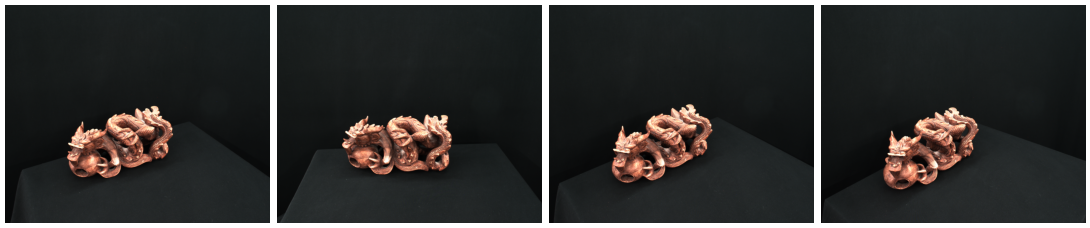

In [11]:
queries = [str(p.relative_to(images_queries)) for p in images_queries.iterdir()]
print(len(queries), " queries images")
print(sorted(queries))
plot_images([read_image(images_queries / r) for r in queries[:4]], dpi=50)

**features_query** - файл с features для каждой картинки из папки query, извлеченными при помощи feature_conf

**matches_query** - файл с matches для каждой пары картинок (mapping -> query), извлеченными при помощи matcher_conf

In [12]:
features_query = outputs / 'features_query.h5'
matches_query = outputs / 'matches_query.h5'

references_registered = [model.images[i].name for i in model.reg_image_ids()]

extract_features.main(feature_conf, 
                      images_all, 
                      image_list=queries, 
                      feature_path=features_query)

pairs_from_exhaustive.main(loc_pairs, 
                           image_list=queries, 
                           ref_list=references_registered)

[2022/10/06 21:30:10 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/97 [00:00<?, ?it/s]

[2022/10/06 21:30:29 hloc INFO] Finished exporting features.
[2022/10/06 21:30:29 hloc INFO] Found 291 pairs.


In [13]:
match_features.main(matcher_conf, 
                    loc_pairs, 
                    features=features_query, 
                    matches=matches_query, 
                    features_ref=features);

[2022/10/06 21:30:29 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/291 [00:00<?, ?it/s]

[2022/10/06 21:30:52 hloc INFO] Finished exporting matches.


На данном этапе мы создаем объект QueryLocalizer, который принимает *model* (pycolmap.Reconstruction объект, модель, на основе которой мы будем находить новые позы для изображений), *conf* (конфиг для query localizer), *dense_features* (dense features из SfM реконструкции).

Здесь описано как можно настроить конфигурацию для query localization. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [14]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

loc_conf = {
        "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
        "PnP": {  # initial pose estimation with PnP+RANSAC
            'estimation': {'ransac': {'max_error': 12.0}},
            'refinement': {'refine_focal_length': False, 
                           'refine_extra_params': False},
        },
        "QBA": {  # query pose refinement
            "optimizer:": {'refine_focal_length': False, 
                           'refine_extra_params': False},
        }
    }


ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]
dense_features = sfm_outputs["feature_manager"]


# localizer computes references for the entire reconstruction at init
# Parameters:
# - config: Union[dict,DictConfig]: config of localization (use {} for default)
# - reconstruction: pycolmap.Reconstruction; reference COLMAP reconstruction
# - feature_manager: features of reference reconstruction

localizer = QueryLocalizer(model, 
                           conf=loc_conf, 
                           dense_features=dense_features)

[2022/10/06 21:30:54 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/06 21:30:54 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


[2022/10/06 21:30:54 pixsfm INFO] Extracting references.


100%[████████████████████] 386/386 [00:00, 77200.0it/s]


[2022/10/06 21:30:54 pixsfm INFO] Reference Extraction Time: 0.010366s


Объявляем какие параметры камеры мы хотим использовать для того чтобы локализовать query ихображение. Тут я использую камеру с теми же параметрами, которые использовались для построения SfM на основе изображений из папки mapping.

In [15]:
_cams = read_cameras_binary(str(exp_loc / 'hloc/cameras.bin'))
cam_info = _cams[1]
print(_cams[1])

pinhole_camera = pycolmap.Camera(
                            model='PINHOLE',
                            width=cam_info.width,
                            height=cam_info.height,
                            params=cam_info.params)
    
print("Camera info --> ", pinhole_camera)

Camera(id=1, model='PINHOLE', width=2368, height=1952, params=array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652]))
Camera info -->  <Camera 'camera_id=Invalid, model=PINHOLE, width=2368, height=1952, num_params=4'>


# Query Localization (1 query)

Находим позу для первого query изображения при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment).

In [22]:
query = sorted(queries)[0]

ret, log = pose_from_cluster(localizer, 
                             query, 
                             pinhole_camera, 
                             ref_ids, 
                             features_query, 
                             matches_query, 
                             image_path=images_all / query)

[2022/10/06 21:33:49 pixsfm INFO] Start features exctraction.


None True


[2022/10/06 21:33:50 pixsfm INFO] Get references for this query.
[2022/10/06 21:33:50 pixsfm INFO] Run QKA


[2022/10/06 21:33:50 pixsfm INFO] QKA Time: 0.091181s, cost change: 0.0464484 --> 0.028462


[2022/10/06 21:33:50 pixsfm INFO] Running PnP with 339 correspondences.
[2022/10/06 21:33:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:33:50 pixsfm INFO]  Run QBA


[2022/10/06 21:33:51 pixsfm INFO] QBA Time: 0.112053s, cost change: 0.0178618 --> 0.0178592


[2022/10/06 21:33:51 pixsfm INFO] We recompute the inliers from the final pose


found 332/339 inlier correspondences.


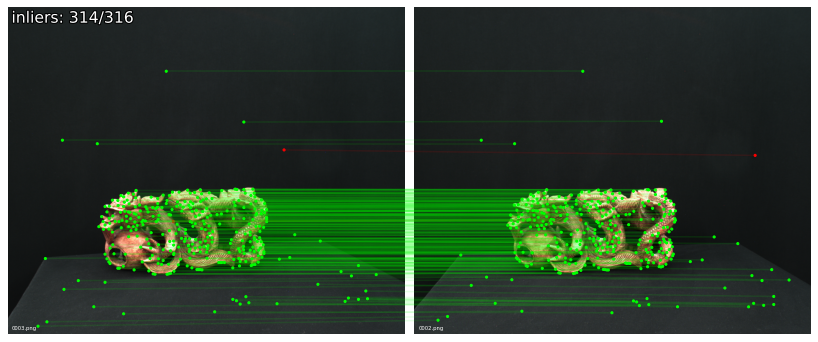

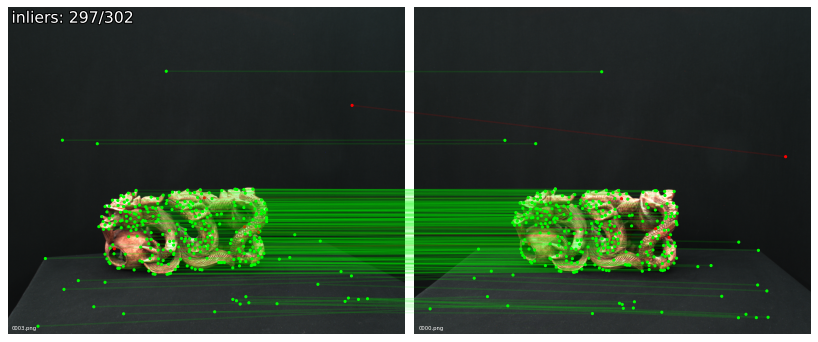

In [23]:
print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')

visualization.visualize_loc_from_log(images_all, 
                         query, 
                         log, 
                         model, 
                         top_k_db=2)

# Visualization of first query

In [24]:
fig3d = init_figure()

pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                   name=query, legendgroup="refined")
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
fig3d.show()
fig3d.write_html(result_dir / "dragon_one_query_localizer.html")

# Query Localization (all queries)

Находим позу для всех query изображений при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment). Для нахождения позы в среднем на одну картинку размером 2368х1952 уходит 3 минуты.

In [19]:
result_dict = {}
extra_dict = {}

for k, query in enumerate(sorted(queries)):
    print(f'Current query image --> {query}')

    ret, log = pose_from_cluster(localizer, 
                                 query, 
                                 pinhole_camera, 
                                 ref_ids, 
                                 features_query, 
                                 matches_query, 
                                 image_path=images_all / query)    
    
    print("ret --> ", ret['qvec'], ret['tvec'], ret['camera'])

    image_id = int(Path(query).stem) + 1
    
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=ret['qvec'], 
                tvec=ret['tvec'],
                camera_id=cam_info.id, 
                name=query,
                xys= np.array([]), 
                point3D_ids= np.array([]),
    )
    
    extra_dict.update({
        'id': int(Path(query).stem) + 1,
        'qvec': ret['qvec'],
        'tvec': ret['tvec'],
        'camera': ret['camera'],
    })
    

[2022/10/06 21:31:01 pixsfm INFO] Start features exctraction.


Current query image --> 0003.png
None True


[2022/10/06 21:31:01 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:01 pixsfm INFO] Run QKA


[2022/10/06 21:31:01 pixsfm INFO] QKA Time: 0.0875711s, cost change: 0.0464484 --> 0.028462


[2022/10/06 21:31:02 pixsfm INFO] Running PnP with 339 correspondences.
[2022/10/06 21:31:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:02 pixsfm INFO]  Run QBA


[2022/10/06 21:31:02 pixsfm INFO] QBA Time: 0.119061s, cost change: 0.0178618 --> 0.0178592


[2022/10/06 21:31:02 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 9.92928419e-01  7.40741809e-05 -1.18390343e-01 -8.76791984e-03] [ 9.89895101 -0.07947843  1.30604391] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0004.png


[2022/10/06 21:31:02 pixsfm INFO] Start features exctraction.


None True


[2022/10/06 21:31:02 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:02 pixsfm INFO] Run QKA


[2022/10/06 21:31:02 pixsfm INFO] QKA Time: 0.0883551s, cost change: 0.0511106 --> 0.0333187


[2022/10/06 21:31:02 pixsfm INFO] Running PnP with 318 correspondences.
[2022/10/06 21:31:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:02 pixsfm INFO]  Run QBA


[2022/10/06 21:31:02 pixsfm INFO] QBA Time: 0.0949531s, cost change: 0.0193041 --> 0.0192997


[2022/10/06 21:31:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:02 pixsfm INFO] Start features exctraction.


ret -->  [ 9.87447533e-01  2.49401899e-04 -1.57520286e-01 -1.16046391e-02] [14.76129206 -0.13062346  2.48665719] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0005.png
None True


[2022/10/06 21:31:03 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:03 pixsfm INFO] Run QKA


[2022/10/06 21:31:03 pixsfm INFO] QKA Time: 0.0855911s, cost change: 0.0524493 --> 0.0367476


[2022/10/06 21:31:03 pixsfm INFO] Running PnP with 291 correspondences.
[2022/10/06 21:31:03 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:03 pixsfm INFO]  Run QBA


[2022/10/06 21:31:03 pixsfm INFO] QBA Time: 0.219549s, cost change: 0.0204024 --> 0.0203917


[2022/10/06 21:31:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:03 pixsfm INFO] Start features exctraction.


ret -->  [ 9.80359624e-01  4.44876822e-04 -1.96687609e-01 -1.44497365e-02] [19.54881028 -0.20278398  4.06671496] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0006.png
None True


[2022/10/06 21:31:04 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:04 pixsfm INFO] Run QKA


[2022/10/06 21:31:04 pixsfm INFO] QKA Time: 0.0814221s, cost change: 0.0548765 --> 0.0398906


[2022/10/06 21:31:04 pixsfm INFO] Running PnP with 285 correspondences.
[2022/10/06 21:31:04 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:04 pixsfm INFO]  Run QBA


[2022/10/06 21:31:04 pixsfm INFO] QBA Time: 0.192337s, cost change: 0.0217278 --> 0.0217072


[2022/10/06 21:31:04 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:04 pixsfm INFO] Start features exctraction.


ret -->  [ 9.71703044e-01  7.18272097e-04 -2.35576785e-01 -1.72120855e-02] [24.18532506 -0.28592003  6.04767547] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0007.png
None True


[2022/10/06 21:31:05 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:05 pixsfm INFO] Run QKA


[2022/10/06 21:31:05 pixsfm INFO] QKA Time: 0.0911119s, cost change: 0.0563216 --> 0.0424644


[2022/10/06 21:31:05 pixsfm INFO] Running PnP with 268 correspondences.
[2022/10/06 21:31:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:05 pixsfm INFO]  Run QBA


[2022/10/06 21:31:05 pixsfm INFO] QBA Time: 0.145288s, cost change: 0.0225194 --> 0.0225135


[2022/10/06 21:31:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:05 pixsfm INFO] Start features exctraction.


ret -->  [ 9.61443200e-01  8.09834082e-04 -2.74272029e-01 -2.00292643e-02] [28.6596804  -0.43470985  8.38993955] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0008.png
None True


[2022/10/06 21:31:06 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:06 pixsfm INFO] Run QKA


[2022/10/06 21:31:06 pixsfm INFO] QKA Time: 0.106914s, cost change: 0.0585432 --> 0.0451291


[2022/10/06 21:31:06 pixsfm INFO] Running PnP with 257 correspondences.
[2022/10/06 21:31:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:06 pixsfm INFO]  Run QBA


[2022/10/06 21:31:06 pixsfm INFO] QBA Time: 0.209661s, cost change: 0.0230763 --> 0.0230681


[2022/10/06 21:31:06 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94967263  0.00111702 -0.31242785 -0.02257182] [32.94603747 -0.57861117 11.07273705] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0009.png
None True


[2022/10/06 21:31:07 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:07 pixsfm INFO] Run QKA


[2022/10/06 21:31:07 pixsfm INFO] QKA Time: 0.115354s, cost change: 0.060282 --> 0.0483711


[2022/10/06 21:31:07 pixsfm INFO] Running PnP with 233 correspondences.
[2022/10/06 21:31:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:07 pixsfm INFO]  Run QBA


[2022/10/06 21:31:07 pixsfm INFO] QBA Time: 0.167284s, cost change: 0.0234707 --> 0.0234232


[2022/10/06 21:31:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93625063  0.00158387 -0.35043191 -0.02509435] [37.05680069 -0.72536944 14.11538629] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0010.png
None True


[2022/10/06 21:31:08 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:08 pixsfm INFO] Run QKA


[2022/10/06 21:31:08 pixsfm INFO] QKA Time: 0.073045s, cost change: 0.060618 --> 0.0489043


[2022/10/06 21:31:08 pixsfm INFO] Running PnP with 216 correspondences.
[2022/10/06 21:31:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:08 pixsfm INFO]  Run QBA


[2022/10/06 21:31:08 pixsfm INFO] QBA Time: 0.195137s, cost change: 0.024276 --> 0.0242179


[2022/10/06 21:31:08 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92112397  0.00148394 -0.38829392 -0.02750034] [40.93470582 -0.9676592  17.47476214] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0011.png
None True


[2022/10/06 21:31:08 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:09 pixsfm INFO] Run QKA


[2022/10/06 21:31:09 pixsfm INFO] QKA Time: 0.118215s, cost change: 0.0613228 --> 0.0500986


[2022/10/06 21:31:09 pixsfm INFO] Running PnP with 203 correspondences.
[2022/10/06 21:31:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:09 pixsfm INFO]  Run QBA


[2022/10/06 21:31:09 pixsfm INFO] QBA Time: 0.174458s, cost change: 0.0243504 --> 0.0243374


[2022/10/06 21:31:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90469855  0.00111452 -0.42498755 -0.03008124] [44.47741702 -1.25201321 21.11975043] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0012.png
None True


[2022/10/06 21:31:09 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:09 pixsfm INFO] Run QKA


[2022/10/06 21:31:09 pixsfm INFO] QKA Time: 0.0571411s, cost change: 0.0630157 --> 0.0523029


[2022/10/06 21:31:09 pixsfm INFO] Running PnP with 190 correspondences.
[2022/10/06 21:31:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:09 pixsfm INFO]  Run QBA


[2022/10/06 21:31:10 pixsfm INFO] QBA Time: 0.125587s, cost change: 0.0248791 --> 0.0248603


[2022/10/06 21:31:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88833669  0.03230394 -0.45536021 -0.04961307] [47.30733211  1.2183232  24.64093272] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0013.png
None True


[2022/10/06 21:31:10 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:10 pixsfm INFO] Run QKA


[2022/10/06 21:31:10 pixsfm INFO] QKA Time: 0.125931s, cost change: 0.0616669 --> 0.051201


[2022/10/06 21:31:10 pixsfm INFO] Running PnP with 221 correspondences.
[2022/10/06 21:31:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:10 pixsfm INFO]  Run QBA


[2022/10/06 21:31:10 pixsfm INFO] QBA Time: 0.131132s, cost change: 0.0245701 --> 0.0245375


[2022/10/06 21:31:11 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.90637532  0.03314332 -0.41864713 -0.04604221] [43.95052851  1.78387387 20.73958327] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0014.png


[2022/10/06 21:31:11 pixsfm INFO] Start features exctraction.


None True


[2022/10/06 21:31:11 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:11 pixsfm INFO] Run QKA


[2022/10/06 21:31:11 pixsfm INFO] QKA Time: 0.116094s, cost change: 0.0617787 --> 0.0501431


[2022/10/06 21:31:11 pixsfm INFO] Running PnP with 229 correspondences.
[2022/10/06 21:31:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:11 pixsfm INFO]  Run QBA


[2022/10/06 21:31:12 pixsfm INFO] QBA Time: 0.312589s, cost change: 0.0241984 --> 0.0241645


[2022/10/06 21:31:12 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:12 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92257023  0.0336871  -0.38204234 -0.04210696] [40.37417759  2.26955975 17.08701914] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0015.png
None True


[2022/10/06 21:31:12 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:12 pixsfm INFO] Run QKA


[2022/10/06 21:31:12 pixsfm INFO] QKA Time: 0.0835919s, cost change: 0.0599413 --> 0.0481886


[2022/10/06 21:31:12 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/06 21:31:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:12 pixsfm INFO]  Run QBA


[2022/10/06 21:31:12 pixsfm INFO] QBA Time: 0.098047s, cost change: 0.0237137 --> 0.0236841


[2022/10/06 21:31:12 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:12 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93759585  0.03388125 -0.34394522 -0.03831138] [36.42580369  2.68114076 13.73065868] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0016.png
None True


[2022/10/06 21:31:13 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:13 pixsfm INFO] Run QKA


[2022/10/06 21:31:13 pixsfm INFO] QKA Time: 0.10776s, cost change: 0.0591721 --> 0.0457113


[2022/10/06 21:31:13 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/06 21:31:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:13 pixsfm INFO]  Run QBA


[2022/10/06 21:31:13 pixsfm INFO] QBA Time: 0.157275s, cost change: 0.0233015 --> 0.023276


[2022/10/06 21:31:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95073648  0.03395558 -0.30622924 -0.0342171 ] [32.31438249  3.04317625 10.76214727] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0017.png
None True


[2022/10/06 21:31:14 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:14 pixsfm INFO] Run QKA


[2022/10/06 21:31:14 pixsfm INFO] QKA Time: 0.0761609s, cost change: 0.0575167 --> 0.0430534


[2022/10/06 21:31:14 pixsfm INFO] Running PnP with 273 correspondences.
[2022/10/06 21:31:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:14 pixsfm INFO]  Run QBA


[2022/10/06 21:31:14 pixsfm INFO] QBA Time: 0.206403s, cost change: 0.0227846 --> 0.0227686


[2022/10/06 21:31:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9624745   0.03434396 -0.2674894  -0.03021189] [27.94042904  3.4033046   8.0877152 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0018.png
None True


[2022/10/06 21:31:15 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:15 pixsfm INFO] Run QKA


[2022/10/06 21:31:15 pixsfm INFO] QKA Time: 0.0668929s, cost change: 0.0555295 --> 0.0407298


[2022/10/06 21:31:15 pixsfm INFO] Running PnP with 290 correspondences.
[2022/10/06 21:31:15 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:15 pixsfm INFO]  Run QBA


[2022/10/06 21:31:15 pixsfm INFO] QBA Time: 0.147436s, cost change: 0.0222427 --> 0.0222352


[2022/10/06 21:31:15 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:15 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97248641  0.03460593 -0.22890911 -0.02594677] [23.4541736   3.68852959  5.77669234] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0019.png
None True


[2022/10/06 21:31:16 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:16 pixsfm INFO] Run QKA


[2022/10/06 21:31:16 pixsfm INFO] QKA Time: 0.076848s, cost change: 0.0535838 --> 0.0378997


[2022/10/06 21:31:16 pixsfm INFO] Running PnP with 305 correspondences.
[2022/10/06 21:31:16 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:16 pixsfm INFO]  Run QBA


[2022/10/06 21:31:16 pixsfm INFO] QBA Time: 0.230133s, cost change: 0.0216148 --> 0.0216115


[2022/10/06 21:31:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98096594  0.0344754  -0.18985607 -0.0217245 ] [18.75958243  3.90559533  3.87822574] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0020.png
None True


[2022/10/06 21:31:17 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:17 pixsfm INFO] Run QKA


[2022/10/06 21:31:17 pixsfm INFO] QKA Time: 0.081147s, cost change: 0.0503615 --> 0.0329632


[2022/10/06 21:31:17 pixsfm INFO] Running PnP with 315 correspondences.
[2022/10/06 21:31:17 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:17 pixsfm INFO]  Run QBA


[2022/10/06 21:31:17 pixsfm INFO] QBA Time: 0.311715s, cost change: 0.0206579 --> 0.0206506


[2022/10/06 21:31:17 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:17 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98779768  0.03470671 -0.15082875 -0.01737485] [13.97975274  4.13096713  2.35222287] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0021.png
None True


[2022/10/06 21:31:18 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:18 pixsfm INFO] Run QKA


[2022/10/06 21:31:18 pixsfm INFO] QKA Time: 0.099364s, cost change: 0.0489066 --> 0.0302357


[2022/10/06 21:31:18 pixsfm INFO] Running PnP with 339 correspondences.
[2022/10/06 21:31:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:18 pixsfm INFO]  Run QBA


[2022/10/06 21:31:18 pixsfm INFO] QBA Time: 0.197125s, cost change: 0.0199446 --> 0.0199394


[2022/10/06 21:31:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99309028  0.03462749 -0.11137157 -0.01300054] [9.03066491 4.2400257  1.23592404] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0022.png
None True


[2022/10/06 21:31:19 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:19 pixsfm INFO] Run QKA


[2022/10/06 21:31:19 pixsfm INFO] QKA Time: 0.0859609s, cost change: 0.0452516 --> 0.0261765


[2022/10/06 21:31:19 pixsfm INFO] Running PnP with 357 correspondences.
[2022/10/06 21:31:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:19 pixsfm INFO]  Run QBA


[2022/10/06 21:31:19 pixsfm INFO] QBA Time: 0.259363s, cost change: 0.0192067 --> 0.0191897


[2022/10/06 21:31:19 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:19 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99675457  0.03498603 -0.07200292 -0.00847898] [4.09659048 4.39923655 0.51117425] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0023.png
None True


[2022/10/06 21:31:19 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:19 pixsfm INFO] Run QKA


[2022/10/06 21:31:20 pixsfm INFO] QKA Time: 0.0930021s, cost change: 0.0456229 --> 0.0262466


[2022/10/06 21:31:20 pixsfm INFO] Running PnP with 358 correspondences.
[2022/10/06 21:31:20 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:20 pixsfm INFO]  Run QBA


[2022/10/06 21:31:20 pixsfm INFO] QBA Time: 0.328304s, cost change: 0.0191126 --> 0.0190949


[2022/10/06 21:31:20 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:20 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99887376  0.03480105 -0.03200114 -0.00400311] [-0.96532016  4.41350707  0.20259839] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0024.png
None True


[2022/10/06 21:31:21 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:21 pixsfm INFO] Run QKA


[2022/10/06 21:31:21 pixsfm INFO] QKA Time: 0.0820849s, cost change: 0.0500525 --> 0.0333261


[2022/10/06 21:31:21 pixsfm INFO] Running PnP with 337 correspondences.
[2022/10/06 21:31:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:21 pixsfm INFO]  Run QBA


[2022/10/06 21:31:21 pixsfm INFO] QBA Time: 0.483971s, cost change: 0.0224038 --> 0.0223119


[2022/10/06 21:31:21 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:21 pixsfm INFO] Start features exctraction.


ret -->  [ 9.97296121e-01  7.34741066e-02 -7.86281995e-04 -1.17649297e-03] [-4.90546562  9.30389687  0.54133627] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0025.png
None True


[2022/10/06 21:31:22 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:22 pixsfm INFO] Run QKA


[2022/10/06 21:31:22 pixsfm INFO] QKA Time: 0.0788331s, cost change: 0.0494128 --> 0.0305909


[2022/10/06 21:31:22 pixsfm INFO] Running PnP with 346 correspondences.
[2022/10/06 21:31:22 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:22 pixsfm INFO]  Run QBA


[2022/10/06 21:31:22 pixsfm INFO] QBA Time: 0.527148s, cost change: 0.0224702 --> 0.0222871


[2022/10/06 21:31:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99636774  0.07420585 -0.04115412 -0.00715208] [0.23010331 9.37476749 0.53694076] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0026.png
None True


[2022/10/06 21:31:23 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:23 pixsfm INFO] Run QKA


[2022/10/06 21:31:23 pixsfm INFO] QKA Time: 0.0748858s, cost change: 0.0486925 --> 0.0322361


[2022/10/06 21:31:23 pixsfm INFO] Running PnP with 333 correspondences.
[2022/10/06 21:31:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:23 pixsfm INFO]  Run QBA


[2022/10/06 21:31:24 pixsfm INFO] QBA Time: 0.481345s, cost change: 0.0225604 --> 0.0224057


[2022/10/06 21:31:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99383749  0.07402927 -0.08142581 -0.01328674] [5.34507764 9.2726195  0.94163118] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0027.png
None True


[2022/10/06 21:31:24 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:24 pixsfm INFO] Run QKA


[2022/10/06 21:31:24 pixsfm INFO] QKA Time: 0.0650351s, cost change: 0.0513197 --> 0.0354762


[2022/10/06 21:31:24 pixsfm INFO] Running PnP with 325 correspondences.
[2022/10/06 21:31:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:24 pixsfm INFO]  Run QBA


[2022/10/06 21:31:24 pixsfm INFO] QBA Time: 0.150046s, cost change: 0.0228607 --> 0.0228214


[2022/10/06 21:31:24 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.99018679  0.06911603 -0.11983958 -0.01978829] [10.13994208  8.4971574   1.86226586] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0028.png


[2022/10/06 21:31:25 pixsfm INFO] Start features exctraction.


None True


[2022/10/06 21:31:25 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:25 pixsfm INFO] Run QKA


[2022/10/06 21:31:25 pixsfm INFO] QKA Time: 0.073369s, cost change: 0.05325 --> 0.0377148


[2022/10/06 21:31:25 pixsfm INFO] Running PnP with 309 correspondences.
[2022/10/06 21:31:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:25 pixsfm INFO]  Run QBA


[2022/10/06 21:31:25 pixsfm INFO] QBA Time: 0.219461s, cost change: 0.0230841 --> 0.0230311


[2022/10/06 21:31:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98449782  0.06877339 -0.15927511 -0.02580123] [15.05318662  8.23532711  3.0887233 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0029.png
None True


[2022/10/06 21:31:26 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:26 pixsfm INFO] Run QKA


[2022/10/06 21:31:26 pixsfm INFO] QKA Time: 0.140446s, cost change: 0.0536996 --> 0.0410096


[2022/10/06 21:31:26 pixsfm INFO] Running PnP with 294 correspondences.
[2022/10/06 21:31:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:26 pixsfm INFO]  Run QBA


[2022/10/06 21:31:26 pixsfm INFO] QBA Time: 0.308711s, cost change: 0.0234509 --> 0.0234241


[2022/10/06 21:31:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97733249  0.06828083 -0.19787419 -0.03169766] [19.79104701  7.90645765  4.71862231] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0030.png
None True


[2022/10/06 21:31:27 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:27 pixsfm INFO] Run QKA


[2022/10/06 21:31:27 pixsfm INFO] QKA Time: 0.0895531s, cost change: 0.0572149 --> 0.0428914


[2022/10/06 21:31:27 pixsfm INFO] Running PnP with 304 correspondences.
[2022/10/06 21:31:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:27 pixsfm INFO]  Run QBA


[2022/10/06 21:31:27 pixsfm INFO] QBA Time: 0.257123s, cost change: 0.0237931 --> 0.0237358


[2022/10/06 21:31:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96839783  0.06784379 -0.23707045 -0.03742289] [24.47596347  7.52592203  6.72977249] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0031.png
None True


[2022/10/06 21:31:28 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:28 pixsfm INFO] Run QKA


[2022/10/06 21:31:28 pixsfm INFO] QKA Time: 0.097254s, cost change: 0.0591903 --> 0.0461507


[2022/10/06 21:31:28 pixsfm INFO] Running PnP with 271 correspondences.
[2022/10/06 21:31:28 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:28 pixsfm INFO]  Run QBA


[2022/10/06 21:31:28 pixsfm INFO] QBA Time: 0.276677s, cost change: 0.0240816 --> 0.0240574


[2022/10/06 21:31:28 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:29 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95762553  0.06808784 -0.27657266 -0.04271944] [29.08181111  7.15080122  9.18315433] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0032.png
None True


[2022/10/06 21:31:29 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:29 pixsfm INFO] Run QKA


[2022/10/06 21:31:29 pixsfm INFO] QKA Time: 0.0710781s, cost change: 0.059413 --> 0.0464355


[2022/10/06 21:31:29 pixsfm INFO] Running PnP with 242 correspondences.
[2022/10/06 21:31:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:29 pixsfm INFO]  Run QBA


[2022/10/06 21:31:29 pixsfm INFO] QBA Time: 0.313567s, cost change: 0.0243199 --> 0.0243089


[2022/10/06 21:31:29 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:29 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9453121   0.06693931 -0.31551191 -0.04854275] [33.45810606  6.52546504 11.92931311] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0033.png
None True


[2022/10/06 21:31:30 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:30 pixsfm INFO] Run QKA


[2022/10/06 21:31:30 pixsfm INFO] QKA Time: 0.122013s, cost change: 0.0608995 --> 0.048428


[2022/10/06 21:31:30 pixsfm INFO] Running PnP with 249 correspondences.
[2022/10/06 21:31:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:30 pixsfm INFO]  Run QBA


[2022/10/06 21:31:31 pixsfm INFO] QBA Time: 0.28408s, cost change: 0.0243833 --> 0.0243776


[2022/10/06 21:31:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93145717  0.06650422 -0.35361657 -0.05403752] [37.57134636  5.9438555  15.0331687 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0034.png
None True


[2022/10/06 21:31:31 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:31 pixsfm INFO] Run QKA


[2022/10/06 21:31:31 pixsfm INFO] QKA Time: 0.086694s, cost change: 0.0623873 --> 0.050451


[2022/10/06 21:31:31 pixsfm INFO] Running PnP with 217 correspondences.
[2022/10/06 21:31:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:31 pixsfm INFO]  Run QBA


[2022/10/06 21:31:31 pixsfm INFO] QBA Time: 0.248418s, cost change: 0.0247719 --> 0.0247618


[2022/10/06 21:31:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91586949  0.06549937 -0.39165414 -0.05916038] [41.46092509  5.23466785 18.53738279] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0035.png
None True


[2022/10/06 21:31:32 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:32 pixsfm INFO] Run QKA


[2022/10/06 21:31:32 pixsfm INFO] QKA Time: 0.0850639s, cost change: 0.06327 --> 0.052109


[2022/10/06 21:31:32 pixsfm INFO] Running PnP with 203 correspondences.
[2022/10/06 21:31:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:32 pixsfm INFO]  Run QBA


[2022/10/06 21:31:32 pixsfm INFO] QBA Time: 0.172985s, cost change: 0.0248816 --> 0.0248683


[2022/10/06 21:31:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.8988803   0.06452381 -0.42859158 -0.06449913] [45.00535795  4.46953761 22.25816947] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0036.png
None True


[2022/10/06 21:31:33 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:33 pixsfm INFO] Run QKA


[2022/10/06 21:31:33 pixsfm INFO] QKA Time: 0.1324s, cost change: 0.0655091 --> 0.0540406


[2022/10/06 21:31:33 pixsfm INFO] Running PnP with 186 correspondences.
[2022/10/06 21:31:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:33 pixsfm INFO]  Run QBA


[2022/10/06 21:31:33 pixsfm INFO] QBA Time: 0.226921s, cost change: 0.0254767 --> 0.0254279


[2022/10/06 21:31:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88645685  0.09450294 -0.44481139 -0.08605968] [46.66461551  6.62782939 24.90762876] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0037.png
None True


[2022/10/06 21:31:34 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:34 pixsfm INFO] Run QKA


[2022/10/06 21:31:34 pixsfm INFO] QKA Time: 0.0987921s, cost change: 0.0634934 --> 0.0527861


[2022/10/06 21:31:34 pixsfm INFO] Running PnP with 213 correspondences.
[2022/10/06 21:31:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:34 pixsfm INFO]  Run QBA


[2022/10/06 21:31:34 pixsfm INFO] QBA Time: 0.185824s, cost change: 0.0254832 --> 0.0254659


[2022/10/06 21:31:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90321241  0.0963891  -0.41067657 -0.07912797] [43.51163976  7.68409411 21.07196351] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0038.png
None True


[2022/10/06 21:31:35 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:35 pixsfm INFO] Run QKA


[2022/10/06 21:31:35 pixsfm INFO] QKA Time: 0.097168s, cost change: 0.0617565 --> 0.0515686


[2022/10/06 21:31:35 pixsfm INFO] Running PnP with 237 correspondences.
[2022/10/06 21:31:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:35 pixsfm INFO]  Run QBA


[2022/10/06 21:31:35 pixsfm INFO] QBA Time: 0.321225s, cost change: 0.0252891 --> 0.0252719


[2022/10/06 21:31:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92101161  0.09914452 -0.36969998 -0.07231811] [39.41928295  8.92736396 17.3293023 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0039.png
None True


[2022/10/06 21:31:36 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:36 pixsfm INFO] Run QKA


[2022/10/06 21:31:36 pixsfm INFO] QKA Time: 0.103002s, cost change: 0.0613454 --> 0.0500505


[2022/10/06 21:31:36 pixsfm INFO] Running PnP with 241 correspondences.
[2022/10/06 21:31:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:36 pixsfm INFO]  Run QBA


[2022/10/06 21:31:36 pixsfm INFO] QBA Time: 0.374451s, cost change: 0.0252733 --> 0.0252397


[2022/10/06 21:31:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93597443  0.10073438 -0.33102047 -0.0650377 ] [35.31163243  9.89099515 14.0243668 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0040.png
None True


[2022/10/06 21:31:37 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:37 pixsfm INFO] Run QKA


[2022/10/06 21:31:37 pixsfm INFO] QKA Time: 0.144673s, cost change: 0.0601812 --> 0.0476124


[2022/10/06 21:31:37 pixsfm INFO] Running PnP with 268 correspondences.
[2022/10/06 21:31:37 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:37 pixsfm INFO]  Run QBA


[2022/10/06 21:31:37 pixsfm INFO] QBA Time: 0.145146s, cost change: 0.025108 --> 0.0250997


[2022/10/06 21:31:37 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:37 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94892538  0.0990218  -0.29370921 -0.05890843] [31.19259616 10.25729352 11.01606485] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0041.png
None True


[2022/10/06 21:31:38 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:38 pixsfm INFO] Run QKA


[2022/10/06 21:31:38 pixsfm INFO] QKA Time: 0.0852828s, cost change: 0.0583237 --> 0.0459904


[2022/10/06 21:31:38 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/06 21:31:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:38 pixsfm INFO]  Run QBA


[2022/10/06 21:31:38 pixsfm INFO] QBA Time: 0.2165s, cost change: 0.025011 --> 0.024961


[2022/10/06 21:31:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96096475  0.10073774 -0.2524861  -0.05147254] [26.40625028 11.08894187  8.40830968] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0042.png
None True


[2022/10/06 21:31:39 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:39 pixsfm INFO] Run QKA


[2022/10/06 21:31:39 pixsfm INFO] QKA Time: 0.101594s, cost change: 0.0568453 --> 0.0424833


[2022/10/06 21:31:39 pixsfm INFO] Running PnP with 274 correspondences.
[2022/10/06 21:31:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:39 pixsfm INFO]  Run QBA


[2022/10/06 21:31:39 pixsfm INFO] QBA Time: 0.423437s, cost change: 0.0248138 --> 0.0247444


[2022/10/06 21:31:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97108884  0.10104186 -0.21168885 -0.04432658] [21.56242416 11.62469483  6.15104226] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0043.png
None True


[2022/10/06 21:31:40 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:40 pixsfm INFO] Run QKA


[2022/10/06 21:31:40 pixsfm INFO] QKA Time: 0.140775s, cost change: 0.0549765 --> 0.0395646


[2022/10/06 21:31:40 pixsfm INFO] Running PnP with 291 correspondences.
[2022/10/06 21:31:40 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:40 pixsfm INFO]  Run QBA


[2022/10/06 21:31:41 pixsfm INFO] QBA Time: 0.418745s, cost change: 0.0247455 --> 0.024681


[2022/10/06 21:31:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97876596  0.10236488 -0.17377781 -0.0366046 ] [16.94685821 12.18442555  4.4089258 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0044.png
None True


[2022/10/06 21:31:41 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:41 pixsfm INFO] Run QKA


[2022/10/06 21:31:41 pixsfm INFO] QKA Time: 0.0881321s, cost change: 0.0543296 --> 0.03927


[2022/10/06 21:31:41 pixsfm INFO] Running PnP with 307 correspondences.
[2022/10/06 21:31:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:41 pixsfm INFO]  Run QBA


[2022/10/06 21:31:42 pixsfm INFO] QBA Time: 0.397527s, cost change: 0.0246019 --> 0.0245718


[2022/10/06 21:31:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98501298  0.10375241 -0.13474929 -0.02876632] [12.10274027 12.69661931  3.04850514] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0045.png
None True


[2022/10/06 21:31:42 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:42 pixsfm INFO] Run QKA


[2022/10/06 21:31:43 pixsfm INFO] QKA Time: 0.125076s, cost change: 0.0524614 --> 0.0366515


[2022/10/06 21:31:43 pixsfm INFO] Running PnP with 314 correspondences.
[2022/10/06 21:31:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:43 pixsfm INFO]  Run QBA


[2022/10/06 21:31:43 pixsfm INFO] QBA Time: 0.473205s, cost change: 0.0244232 --> 0.0243603


[2022/10/06 21:31:43 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:43 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9897396   0.10459387 -0.0950993  -0.02077891] [ 7.08349294 13.02488051  1.97408911] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0046.png
None True


[2022/10/06 21:31:44 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:44 pixsfm INFO] Run QKA


[2022/10/06 21:31:44 pixsfm INFO] QKA Time: 0.0482461s, cost change: 0.0524439 --> 0.0367767


[2022/10/06 21:31:44 pixsfm INFO] Running PnP with 328 correspondences.
[2022/10/06 21:31:44 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:44 pixsfm INFO]  Run QBA


[2022/10/06 21:31:44 pixsfm INFO] QBA Time: 0.358542s, cost change: 0.0245966 --> 0.0245383


[2022/10/06 21:31:44 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:44 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99297042  0.10475887 -0.05343477 -0.01341852] [ 1.77074575 13.16896892  1.49303318] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0047.png
None True


[2022/10/06 21:31:45 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:45 pixsfm INFO] Run QKA


[2022/10/06 21:31:45 pixsfm INFO] QKA Time: 0.111343s, cost change: 0.0505987 --> 0.0352589


[2022/10/06 21:31:45 pixsfm INFO] Running PnP with 313 correspondences.
[2022/10/06 21:31:45 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:45 pixsfm INFO]  Run QBA


[2022/10/06 21:31:45 pixsfm INFO] QBA Time: 0.507845s, cost change: 0.0241863 --> 0.0238917


[2022/10/06 21:31:45 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:45 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99312072  0.11590277 -0.01587991 -0.00506017] [-2.98264251 14.67421045  1.25208271] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0048.png
None True


[2022/10/06 21:31:46 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:46 pixsfm INFO] Run QKA


[2022/10/06 21:31:46 pixsfm INFO] QKA Time: 0.082654s, cost change: 0.0540877 --> 0.0389415


[2022/10/06 21:31:46 pixsfm INFO] Running PnP with 299 correspondences.
[2022/10/06 21:31:46 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:46 pixsfm INFO]  Run QBA


[2022/10/06 21:31:47 pixsfm INFO] QBA Time: 0.40132s, cost change: 0.0247561 --> 0.024525


[2022/10/06 21:31:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98730408  0.15878157 -0.00286713 -0.00329227] [-4.60667295 20.04986641  2.49020124] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0049.png
None True


[2022/10/06 21:31:47 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:47 pixsfm INFO] Run QKA


[2022/10/06 21:31:47 pixsfm INFO] QKA Time: 0.121501s, cost change: 0.0531044 --> 0.0384324


[2022/10/06 21:31:47 pixsfm INFO] Running PnP with 312 correspondences.
[2022/10/06 21:31:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:47 pixsfm INFO]  Run QBA


[2022/10/06 21:31:48 pixsfm INFO] QBA Time: 0.444621s, cost change: 0.0247877 --> 0.0245748


[2022/10/06 21:31:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98576165  0.16206635 -0.0430938  -0.01230433] [ 0.60567647 20.45666362  2.49693892] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0050.png
None True


[2022/10/06 21:31:48 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:48 pixsfm INFO] Run QKA


[2022/10/06 21:31:48 pixsfm INFO] QKA Time: 0.0713949s, cost change: 0.0545398 --> 0.0394023


[2022/10/06 21:31:48 pixsfm INFO] Running PnP with 288 correspondences.
[2022/10/06 21:31:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:48 pixsfm INFO]  Run QBA


[2022/10/06 21:31:49 pixsfm INFO] QBA Time: 0.434806s, cost change: 0.0254443 --> 0.0254048


[2022/10/06 21:31:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98674893  0.13842855 -0.08134189 -0.02340046] [ 5.43312484 17.26909005  2.95701321] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0051.png
None True


[2022/10/06 21:31:49 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:49 pixsfm INFO] Run QKA


[2022/10/06 21:31:50 pixsfm INFO] QKA Time: 0.100655s, cost change: 0.0559923 --> 0.0407088


[2022/10/06 21:31:50 pixsfm INFO] Running PnP with 298 correspondences.
[2022/10/06 21:31:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:50 pixsfm INFO]  Run QBA


[2022/10/06 21:31:50 pixsfm INFO] QBA Time: 0.368948s, cost change: 0.0248618 --> 0.024775


[2022/10/06 21:31:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9788632   0.16012353 -0.1236101  -0.03013029] [10.94325858 19.79945777  3.78598797] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0052.png
None True


[2022/10/06 21:31:51 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:51 pixsfm INFO] Run QKA


[2022/10/06 21:31:51 pixsfm INFO] QKA Time: 0.087853s, cost change: 0.0569183 --> 0.042632


[2022/10/06 21:31:51 pixsfm INFO] Running PnP with 277 correspondences.
[2022/10/06 21:31:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:51 pixsfm INFO]  Run QBA


[2022/10/06 21:31:51 pixsfm INFO] QBA Time: 0.361336s, cost change: 0.0256252 --> 0.0255684


[2022/10/06 21:31:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97606623  0.13750858 -0.16296716 -0.04275283] [15.75735483 16.51719307  5.08839513] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0053.png
None True


[2022/10/06 21:31:52 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:52 pixsfm INFO] Run QKA


[2022/10/06 21:31:52 pixsfm INFO] QKA Time: 0.104994s, cost change: 0.0581658 --> 0.0449683


[2022/10/06 21:31:52 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/06 21:31:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:52 pixsfm INFO]  Run QBA


[2022/10/06 21:31:52 pixsfm INFO] QBA Time: 0.425038s, cost change: 0.0257693 --> 0.0257247


[2022/10/06 21:31:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9682341   0.13529128 -0.20373214 -0.05207898] [20.80597481 15.74754396  6.82400427] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0054.png
None True


[2022/10/06 21:31:53 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:53 pixsfm INFO] Run QKA


[2022/10/06 21:31:53 pixsfm INFO] QKA Time: 0.107845s, cost change: 0.0583204 --> 0.0465791


[2022/10/06 21:31:53 pixsfm INFO] Running PnP with 284 correspondences.
[2022/10/06 21:31:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:53 pixsfm INFO]  Run QBA


[2022/10/06 21:31:53 pixsfm INFO] QBA Time: 0.349672s, cost change: 0.0257881 --> 0.0256712


[2022/10/06 21:31:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:53 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95922042  0.13353435 -0.24113294 -0.06260722] [25.23054525 14.93539819  8.8098893 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0055.png
None True


[2022/10/06 21:31:54 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:54 pixsfm INFO] Run QKA


[2022/10/06 21:31:54 pixsfm INFO] QKA Time: 0.179911s, cost change: 0.0603158 --> 0.0493526


[2022/10/06 21:31:54 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/06 21:31:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:54 pixsfm INFO]  Run QBA


[2022/10/06 21:31:54 pixsfm INFO] QBA Time: 0.355403s, cost change: 0.0257678 --> 0.025612


[2022/10/06 21:31:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:55 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94779689  0.13518899 -0.27978325 -0.07159829] [29.76498981 14.45631825 11.57538785] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0056.png
None True


[2022/10/06 21:31:55 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:55 pixsfm INFO] Run QKA


[2022/10/06 21:31:55 pixsfm INFO] QKA Time: 0.106317s, cost change: 0.0619307 --> 0.0505246


[2022/10/06 21:31:55 pixsfm INFO] Running PnP with 249 correspondences.
[2022/10/06 21:31:55 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:55 pixsfm INFO]  Run QBA


[2022/10/06 21:31:56 pixsfm INFO] QBA Time: 0.318805s, cost change: 0.0258919 --> 0.0258328


[2022/10/06 21:31:56 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:56 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93297072  0.13248878 -0.32529362 -0.07871738] [34.93869453 13.23102049 14.50320614] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0057.png
None True


[2022/10/06 21:31:56 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:56 pixsfm INFO] Run QKA


[2022/10/06 21:31:56 pixsfm INFO] QKA Time: 0.119093s, cost change: 0.0626698 --> 0.0528823


[2022/10/06 21:31:56 pixsfm INFO] Running PnP with 239 correspondences.
[2022/10/06 21:31:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:56 pixsfm INFO]  Run QBA


[2022/10/06 21:31:57 pixsfm INFO] QBA Time: 0.273183s, cost change: 0.0257738 --> 0.0257314


[2022/10/06 21:31:57 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:57 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91797215  0.13795366 -0.36191898 -0.08550187] [38.94059598 13.09741239 17.69682865] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0058.png
None True


[2022/10/06 21:31:57 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:57 pixsfm INFO] Run QKA


[2022/10/06 21:31:57 pixsfm INFO] QKA Time: 0.109535s, cost change: 0.0653532 --> 0.0548788


[2022/10/06 21:31:57 pixsfm INFO] Running PnP with 220 correspondences.
[2022/10/06 21:31:57 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:57 pixsfm INFO]  Run QBA


[2022/10/06 21:31:58 pixsfm INFO] QBA Time: 0.219738s, cost change: 0.0258292 --> 0.0257512


[2022/10/06 21:31:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90151448  0.13286978 -0.40082628 -0.09463383] [42.85990515 11.41921433 21.49882594] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0059.png
None True


[2022/10/06 21:31:58 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:58 pixsfm INFO] Run QKA


[2022/10/06 21:31:58 pixsfm INFO] QKA Time: 0.1163s, cost change: 0.0669197 --> 0.0578944


[2022/10/06 21:31:58 pixsfm INFO] Running PnP with 229 correspondences.
[2022/10/06 21:31:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:58 pixsfm INFO]  Run QBA


[2022/10/06 21:31:59 pixsfm INFO] QBA Time: 0.217527s, cost change: 0.0263749 --> 0.026337


[2022/10/06 21:31:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:31:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87938193  0.1610917  -0.431253   -0.12148145] [46.06350662 12.68559633 26.17564138] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0060.png
None True


[2022/10/06 21:31:59 pixsfm INFO] Get references for this query.
[2022/10/06 21:31:59 pixsfm INFO] Run QKA


[2022/10/06 21:31:59 pixsfm INFO] QKA Time: 0.0842731s, cost change: 0.0658719 --> 0.0566967


[2022/10/06 21:31:59 pixsfm INFO] Running PnP with 219 correspondences.
[2022/10/06 21:31:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:31:59 pixsfm INFO]  Run QBA


[2022/10/06 21:31:59 pixsfm INFO] QBA Time: 0.234909s, cost change: 0.0259485 --> 0.025934


[2022/10/06 21:31:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89759763  0.16920878 -0.39223275 -0.10881341] [42.39731661 15.11533726 22.25540655] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0061.png
None True


[2022/10/06 21:32:00 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:00 pixsfm INFO] Run QKA


[2022/10/06 21:32:00 pixsfm INFO] QKA Time: 0.112805s, cost change: 0.0647242 --> 0.0541525


[2022/10/06 21:32:00 pixsfm INFO] Running PnP with 236 correspondences.
[2022/10/06 21:32:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:00 pixsfm INFO]  Run QBA


[2022/10/06 21:32:01 pixsfm INFO] QBA Time: 0.291538s, cost change: 0.0261591 --> 0.0260912


[2022/10/06 21:32:01 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:01 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91429021  0.17423503 -0.352184   -0.09839714] [38.29524555 16.95482557 18.23086608] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0062.png
None True


[2022/10/06 21:32:01 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:01 pixsfm INFO] Run QKA


[2022/10/06 21:32:01 pixsfm INFO] QKA Time: 0.12333s, cost change: 0.062566 --> 0.0514428


[2022/10/06 21:32:01 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/06 21:32:01 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:01 pixsfm INFO]  Run QBA


[2022/10/06 21:32:02 pixsfm INFO] QBA Time: 0.264119s, cost change: 0.0260093 --> 0.0259975


[2022/10/06 21:32:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92910924  0.18169543 -0.31006593 -0.08718893] [33.7597651  19.05039439 15.07863859] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0063.png
None True


[2022/10/06 21:32:02 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:02 pixsfm INFO] Run QKA


[2022/10/06 21:32:02 pixsfm INFO] QKA Time: 0.14903s, cost change: 0.0612502 --> 0.0500592


[2022/10/06 21:32:02 pixsfm INFO] Running PnP with 249 correspondences.
[2022/10/06 21:32:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:02 pixsfm INFO]  Run QBA


[2022/10/06 21:32:03 pixsfm INFO] QBA Time: 0.308557s, cost change: 0.0260556 --> 0.0259817


[2022/10/06 21:32:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94162275  0.18748092 -0.26897806 -0.07647413] [29.03529021 20.75333874 12.16424107] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0064.png
None True


[2022/10/06 21:32:03 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:03 pixsfm INFO] Run QKA


[2022/10/06 21:32:03 pixsfm INFO] QKA Time: 0.113856s, cost change: 0.0598714 --> 0.0473305


[2022/10/06 21:32:03 pixsfm INFO] Running PnP with 262 correspondences.
[2022/10/06 21:32:03 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:03 pixsfm INFO]  Run QBA


[2022/10/06 21:32:04 pixsfm INFO] QBA Time: 0.321106s, cost change: 0.0257243 --> 0.0256673


[2022/10/06 21:32:04 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:04 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95215431  0.19210792 -0.22863429 -0.06498518] [24.25561437 22.18385869  9.71575444] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0065.png
None True


[2022/10/06 21:32:04 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:04 pixsfm INFO] Run QKA


[2022/10/06 21:32:04 pixsfm INFO] QKA Time: 0.154099s, cost change: 0.059599 --> 0.0463989


[2022/10/06 21:32:04 pixsfm INFO] Running PnP with 265 correspondences.
[2022/10/06 21:32:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:05 pixsfm INFO]  Run QBA


[2022/10/06 21:32:05 pixsfm INFO] QBA Time: 0.388201s, cost change: 0.0262776 --> 0.0261952


[2022/10/06 21:32:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:05 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96524715  0.16798041 -0.19144466 -0.05856163] [19.49016662 19.70113356  7.60903435] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0066.png
None True


[2022/10/06 21:32:05 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:05 pixsfm INFO] Run QKA


[2022/10/06 21:32:06 pixsfm INFO] QKA Time: 0.102217s, cost change: 0.0583622 --> 0.0461679


[2022/10/06 21:32:06 pixsfm INFO] Running PnP with 273 correspondences.
[2022/10/06 21:32:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:06 pixsfm INFO]  Run QBA


[2022/10/06 21:32:06 pixsfm INFO] QBA Time: 0.327723s, cost change: 0.0255165 --> 0.0252781


[2022/10/06 21:32:06 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96773205  0.19889861 -0.14866958 -0.0427946 ] [14.30075522 24.2610385   6.10351747] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0067.png
None True


[2022/10/06 21:32:07 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:07 pixsfm INFO] Run QKA


[2022/10/06 21:32:07 pixsfm INFO] QKA Time: 0.105006s, cost change: 0.057587 --> 0.0439899


[2022/10/06 21:32:07 pixsfm INFO] Running PnP with 276 correspondences.
[2022/10/06 21:32:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:07 pixsfm INFO]  Run QBA


[2022/10/06 21:32:07 pixsfm INFO] QBA Time: 0.356939s, cost change: 0.0252903 --> 0.025223


[2022/10/06 21:32:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97283226  0.20217185 -0.10818571 -0.03193412] [ 9.11370147 25.06832272  5.02667279] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0068.png
None True


[2022/10/06 21:32:08 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:08 pixsfm INFO] Run QKA


[2022/10/06 21:32:08 pixsfm INFO] QKA Time: 0.0681379s, cost change: 0.0562362 --> 0.0421095


[2022/10/06 21:32:08 pixsfm INFO] Running PnP with 276 correspondences.
[2022/10/06 21:32:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:08 pixsfm INFO]  Run QBA


[2022/10/06 21:32:08 pixsfm INFO] QBA Time: 0.247421s, cost change: 0.0251365 --> 0.0250001


[2022/10/06 21:32:08 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97635109  0.20398042 -0.06859679 -0.02061596] [ 3.98460194 25.5480028   4.35902209] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0069.png
None True


[2022/10/06 21:32:09 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:09 pixsfm INFO] Run QKA


[2022/10/06 21:32:09 pixsfm INFO] QKA Time: 0.0937421s, cost change: 0.0564408 --> 0.0420995


[2022/10/06 21:32:09 pixsfm INFO] Running PnP with 286 correspondences.
[2022/10/06 21:32:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:09 pixsfm INFO]  Run QBA


[2022/10/06 21:32:09 pixsfm INFO] QBA Time: 0.381534s, cost change: 0.0250956 --> 0.0249337


[2022/10/06 21:32:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97884992  0.20262615 -0.0262865  -0.01022243] [-1.53957976 25.4818584   4.068875  ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0070.png
None True


[2022/10/06 21:32:10 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:10 pixsfm INFO] Run QKA


[2022/10/06 21:32:10 pixsfm INFO] QKA Time: 0.11942s, cost change: 0.0574071 --> 0.0441048


[2022/10/06 21:32:10 pixsfm INFO] Running PnP with 277 correspondences.
[2022/10/06 21:32:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:10 pixsfm INFO]  Run QBA


[2022/10/06 21:32:10 pixsfm INFO] QBA Time: 0.280775s, cost change: 0.0254106 --> 0.0252841


[2022/10/06 21:32:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97004874  0.24285063 -0.00349433 -0.00409953] [-4.44407284 30.32212621  6.18268739] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0071.png
None True


[2022/10/06 21:32:11 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:11 pixsfm INFO] Run QKA


[2022/10/06 21:32:11 pixsfm INFO] QKA Time: 0.076427s, cost change: 0.057471 --> 0.0441894


[2022/10/06 21:32:11 pixsfm INFO] Running PnP with 261 correspondences.
[2022/10/06 21:32:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:11 pixsfm INFO]  Run QBA


[2022/10/06 21:32:11 pixsfm INFO] QBA Time: 0.279949s, cost change: 0.0254242 --> 0.0253131


[2022/10/06 21:32:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96871794  0.24333754 -0.04545377 -0.01750258] [ 1.07875697 30.33867428  6.13517856] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0072.png
None True


[2022/10/06 21:32:12 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:12 pixsfm INFO] Run QKA


[2022/10/06 21:32:12 pixsfm INFO] QKA Time: 0.109252s, cost change: 0.0575186 --> 0.0447996


[2022/10/06 21:32:12 pixsfm INFO] Running PnP with 259 correspondences.
[2022/10/06 21:32:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:12 pixsfm INFO]  Run QBA


[2022/10/06 21:32:12 pixsfm INFO] QBA Time: 0.237698s, cost change: 0.0252532 --> 0.025131


[2022/10/06 21:32:12 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:12 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9655522   0.2432451  -0.08726655 -0.03041897] [ 6.597105   30.10033976  6.60121661] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0073.png
None True


[2022/10/06 21:32:13 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:13 pixsfm INFO] Run QKA


[2022/10/06 21:32:13 pixsfm INFO] QKA Time: 0.088115s, cost change: 0.0585921 --> 0.0463029


[2022/10/06 21:32:13 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/06 21:32:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:13 pixsfm INFO]  Run QBA


[2022/10/06 21:32:13 pixsfm INFO] QBA Time: 0.284205s, cost change: 0.0254293 --> 0.0253392


[2022/10/06 21:32:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9610994   0.24066663 -0.12825224 -0.04380503] [11.94450375 29.39724813  7.48400032] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0074.png
None True


[2022/10/06 21:32:14 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:14 pixsfm INFO] Run QKA


[2022/10/06 21:32:14 pixsfm INFO] QKA Time: 0.0982959s, cost change: 0.0595201 --> 0.0466968


[2022/10/06 21:32:14 pixsfm INFO] Running PnP with 253 correspondences.
[2022/10/06 21:32:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:14 pixsfm INFO]  Run QBA


[2022/10/06 21:32:14 pixsfm INFO] QBA Time: 0.273965s, cost change: 0.0255349 --> 0.0255167


[2022/10/06 21:32:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95531541  0.23589317 -0.16873279 -0.05706252] [17.13515591 28.25703963  8.79786662] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0075.png
None True


[2022/10/06 21:32:15 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:15 pixsfm INFO] Run QKA


[2022/10/06 21:32:15 pixsfm INFO] QKA Time: 0.0831749s, cost change: 0.0602054 --> 0.0485325


[2022/10/06 21:32:15 pixsfm INFO] Running PnP with 246 correspondences.
[2022/10/06 21:32:15 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:15 pixsfm INFO]  Run QBA


[2022/10/06 21:32:15 pixsfm INFO] QBA Time: 0.23664s, cost change: 0.0257768 --> 0.0256856


[2022/10/06 21:32:15 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:15 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94714185  0.23193541 -0.21012536 -0.07053801] [22.31849178 27.01272748 10.66014079] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0076.png
None True


[2022/10/06 21:32:16 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:16 pixsfm INFO] Run QKA


[2022/10/06 21:32:16 pixsfm INFO] QKA Time: 0.125721s, cost change: 0.062765 --> 0.0517466


[2022/10/06 21:32:16 pixsfm INFO] Running PnP with 259 correspondences.
[2022/10/06 21:32:16 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:16 pixsfm INFO]  Run QBA


[2022/10/06 21:32:16 pixsfm INFO] QBA Time: 0.231217s, cost change: 0.026076 --> 0.0260242


[2022/10/06 21:32:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93694287  0.2267716  -0.25246615 -0.0835077 ] [27.46602681 25.43826764 13.02904079] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0077.png
None True


[2022/10/06 21:32:17 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:17 pixsfm INFO] Run QKA


[2022/10/06 21:32:17 pixsfm INFO] QKA Time: 0.117991s, cost change: 0.0633078 --> 0.0522181


[2022/10/06 21:32:17 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/06 21:32:17 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:17 pixsfm INFO]  Run QBA


[2022/10/06 21:32:17 pixsfm INFO] QBA Time: 0.222649s, cost change: 0.0259812 --> 0.025965


[2022/10/06 21:32:17 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:17 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92488658  0.21955063 -0.29510689 -0.09640676] [32.45445423 23.41313559 15.84377812] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0078.png
None True


[2022/10/06 21:32:18 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:18 pixsfm INFO] Run QKA


[2022/10/06 21:32:18 pixsfm INFO] QKA Time: 0.0815599s, cost change: 0.0651529 --> 0.0553059


[2022/10/06 21:32:18 pixsfm INFO] Running PnP with 237 correspondences.
[2022/10/06 21:32:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:18 pixsfm INFO]  Run QBA


[2022/10/06 21:32:18 pixsfm INFO] QBA Time: 0.162051s, cost change: 0.0262109 --> 0.0261654


[2022/10/06 21:32:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91089765  0.21089979 -0.33706867 -0.11032437] [37.11421086 21.04628036 19.15204454] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0079.png
None True


[2022/10/06 21:32:19 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:19 pixsfm INFO] Run QKA


[2022/10/06 21:32:19 pixsfm INFO] QKA Time: 0.0973179s, cost change: 0.0660521 --> 0.0569862


[2022/10/06 21:32:19 pixsfm INFO] Running PnP with 231 correspondences.
[2022/10/06 21:32:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:19 pixsfm INFO]  Run QBA


[2022/10/06 21:32:19 pixsfm INFO] QBA Time: 0.265448s, cost change: 0.026291 --> 0.026261


[2022/10/06 21:32:19 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:19 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89332254  0.20622477 -0.37987455 -0.12305087] [41.61898439 18.96734114 22.94175218] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0080.png
None True


[2022/10/06 21:32:20 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:20 pixsfm INFO] Run QKA


[2022/10/06 21:32:20 pixsfm INFO] QKA Time: 0.104723s, cost change: 0.067308 --> 0.0577904


[2022/10/06 21:32:20 pixsfm INFO] Running PnP with 171 correspondences.
[2022/10/06 21:32:20 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:20 pixsfm INFO]  Run QBA


[2022/10/06 21:32:20 pixsfm INFO] QBA Time: 0.214034s, cost change: 0.0264058 --> 0.0263512


[2022/10/06 21:32:20 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:20 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87510359  0.19975356 -0.41938344 -0.13568257] [45.46433607 16.60118266 26.92609441] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0081.png
None True


[2022/10/06 21:32:20 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:20 pixsfm INFO] Run QKA


[2022/10/06 21:32:21 pixsfm INFO] QKA Time: 0.0785561s, cost change: 0.0674354 --> 0.0582938


[2022/10/06 21:32:21 pixsfm INFO] Running PnP with 124 correspondences.
[2022/10/06 21:32:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:21 pixsfm INFO]  Run QBA


[2022/10/06 21:32:21 pixsfm INFO] QBA Time: 0.158171s, cost change: 0.0259825 --> 0.0259075


[2022/10/06 21:32:21 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.86595034  0.23368931 -0.41468416 -0.15348083] [45.55139516 19.5403209  28.65582748] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0082.png


[2022/10/06 21:32:21 pixsfm INFO] Start features exctraction.


None True


[2022/10/06 21:32:21 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:21 pixsfm INFO] Run QKA


[2022/10/06 21:32:21 pixsfm INFO] QKA Time: 0.116279s, cost change: 0.0657272 --> 0.0566797


[2022/10/06 21:32:21 pixsfm INFO] Running PnP with 206 correspondences.
[2022/10/06 21:32:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:21 pixsfm INFO]  Run QBA


[2022/10/06 21:32:22 pixsfm INFO] QBA Time: 0.200239s, cost change: 0.0262657 --> 0.0262166


[2022/10/06 21:32:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88507757  0.24118629 -0.37307413 -0.13886169] [41.44959252 22.30678486 24.42037953] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0083.png
None True


[2022/10/06 21:32:22 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:22 pixsfm INFO] Run QKA


[2022/10/06 21:32:22 pixsfm INFO] QKA Time: 0.138143s, cost change: 0.064684 --> 0.0553899


[2022/10/06 21:32:22 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/06 21:32:22 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:22 pixsfm INFO]  Run QBA


[2022/10/06 21:32:23 pixsfm INFO] QBA Time: 0.266415s, cost change: 0.0264099 --> 0.0263946


[2022/10/06 21:32:23 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:23 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90305618  0.24818798 -0.32787475 -0.1240581 ] [36.620363   24.91840487 20.45909592] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0084.png
None True


[2022/10/06 21:32:23 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:23 pixsfm INFO] Run QKA


[2022/10/06 21:32:23 pixsfm INFO] QKA Time: 0.118163s, cost change: 0.0644997 --> 0.0550341


[2022/10/06 21:32:23 pixsfm INFO] Running PnP with 260 correspondences.
[2022/10/06 21:32:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:23 pixsfm INFO]  Run QBA


[2022/10/06 21:32:24 pixsfm INFO] QBA Time: 0.28943s, cost change: 0.0263254 --> 0.0262026


[2022/10/06 21:32:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91677565  0.25740769 -0.28593056 -0.10727253] [31.8686093  27.5499941  17.40405879] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0085.png
None True


[2022/10/06 21:32:24 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:24 pixsfm INFO] Run QKA


[2022/10/06 21:32:24 pixsfm INFO] QKA Time: 0.13105s, cost change: 0.0627543 --> 0.051438


[2022/10/06 21:32:24 pixsfm INFO] Running PnP with 253 correspondences.
[2022/10/06 21:32:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:25 pixsfm INFO]  Run QBA


[2022/10/06 21:32:25 pixsfm INFO] QBA Time: 0.244932s, cost change: 0.0259086 --> 0.0258591


[2022/10/06 21:32:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92897511  0.26363439 -0.24328881 -0.09117408] [26.79401635 29.58280245 14.6526413 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0086.png
None True


[2022/10/06 21:32:25 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:25 pixsfm INFO] Run QKA


[2022/10/06 21:32:25 pixsfm INFO] QKA Time: 0.110247s, cost change: 0.0621598 --> 0.0507234


[2022/10/06 21:32:25 pixsfm INFO] Running PnP with 257 correspondences.
[2022/10/06 21:32:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:25 pixsfm INFO]  Run QBA


[2022/10/06 21:32:26 pixsfm INFO] QBA Time: 0.229857s, cost change: 0.0258949 --> 0.0258393


[2022/10/06 21:32:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93855595  0.2713273  -0.19951285 -0.07542452] [21.36525166 31.63182667 12.49622911] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0087.png
None True


[2022/10/06 21:32:26 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:26 pixsfm INFO] Run QKA


[2022/10/06 21:32:26 pixsfm INFO] QKA Time: 0.119731s, cost change: 0.0600297 --> 0.048238


[2022/10/06 21:32:26 pixsfm INFO] Running PnP with 262 correspondences.
[2022/10/06 21:32:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:26 pixsfm INFO]  Run QBA


[2022/10/06 21:32:27 pixsfm INFO] QBA Time: 0.299094s, cost change: 0.0259348 --> 0.0257657


[2022/10/06 21:32:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94674128  0.2747957  -0.15667345 -0.06018063] [15.87555131 32.86686089 10.63314634] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0088.png
None True


[2022/10/06 21:32:27 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:27 pixsfm INFO] Run QKA


[2022/10/06 21:32:27 pixsfm INFO] QKA Time: 0.0913439s, cost change: 0.0596725 --> 0.0472158


[2022/10/06 21:32:27 pixsfm INFO] Running PnP with 244 correspondences.
[2022/10/06 21:32:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:27 pixsfm INFO]  Run QBA


[2022/10/06 21:32:28 pixsfm INFO] QBA Time: 0.238993s, cost change: 0.0256857 --> 0.0255092


[2022/10/06 21:32:28 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:28 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95200968  0.28081075 -0.11344778 -0.04418698] [10.23640137 34.21305937  9.44598897] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0089.png
None True


[2022/10/06 21:32:28 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:28 pixsfm INFO] Run QKA


[2022/10/06 21:32:28 pixsfm INFO] QKA Time: 0.078629s, cost change: 0.0596844 --> 0.047334


[2022/10/06 21:32:28 pixsfm INFO] Running PnP with 236 correspondences.
[2022/10/06 21:32:28 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:28 pixsfm INFO]  Run QBA


[2022/10/06 21:32:29 pixsfm INFO] QBA Time: 0.251269s, cost change: 0.0253615 --> 0.0252457


[2022/10/06 21:32:29 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:29 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95650973  0.28154356 -0.07074163 -0.02860043] [ 4.55700294 34.69270532  8.68860677] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0090.png
None True


[2022/10/06 21:32:29 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:29 pixsfm INFO] Run QKA


[2022/10/06 21:32:29 pixsfm INFO] QKA Time: 0.095341s, cost change: 0.0580631 --> 0.0465806


[2022/10/06 21:32:29 pixsfm INFO] Running PnP with 250 correspondences.
[2022/10/06 21:32:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:29 pixsfm INFO]  Run QBA


[2022/10/06 21:32:30 pixsfm INFO] QBA Time: 0.307946s, cost change: 0.0257084 --> 0.0255408


[2022/10/06 21:32:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95921507  0.28104921 -0.02704568 -0.01365005] [-1.25924423 34.8168013   8.42488877] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0091.png
None True


[2022/10/06 21:32:30 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:30 pixsfm INFO] Run QKA


[2022/10/06 21:32:30 pixsfm INFO] QKA Time: 0.144036s, cost change: 0.0587574 --> 0.0470522


[2022/10/06 21:32:30 pixsfm INFO] Running PnP with 242 correspondences.
[2022/10/06 21:32:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:30 pixsfm INFO]  Run QBA


[2022/10/06 21:32:31 pixsfm INFO] QBA Time: 0.173002s, cost change: 0.0254943 --> 0.0254467


[2022/10/06 21:32:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9473482   0.32013961 -0.00428306 -0.00486473] [-4.30207671 39.22848294 11.26254944] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0092.png
None True


[2022/10/06 21:32:31 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:31 pixsfm INFO] Run QKA


[2022/10/06 21:32:31 pixsfm INFO] QKA Time: 0.12778s, cost change: 0.0594254 --> 0.0470043


[2022/10/06 21:32:31 pixsfm INFO] Running PnP with 232 correspondences.
[2022/10/06 21:32:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:31 pixsfm INFO]  Run QBA


[2022/10/06 21:32:32 pixsfm INFO] QBA Time: 0.265102s, cost change: 0.025601 --> 0.0254955


[2022/10/06 21:32:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94571784  0.3202406  -0.05006225 -0.02361135] [ 1.93684688 39.1708117  11.21400213] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0093.png
None True


[2022/10/06 21:32:32 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:32 pixsfm INFO] Run QKA


[2022/10/06 21:32:32 pixsfm INFO] QKA Time: 0.0638921s, cost change: 0.0583688 --> 0.0469937


[2022/10/06 21:32:32 pixsfm INFO] Running PnP with 232 correspondences.
[2022/10/06 21:32:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:32 pixsfm INFO]  Run QBA


[2022/10/06 21:32:33 pixsfm INFO] QBA Time: 0.210797s, cost change: 0.0254093 --> 0.0253576


[2022/10/06 21:32:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94126121  0.32177216 -0.09333691 -0.04216905] [ 7.8281417  39.01632355 11.96159313] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0094.png
None True


[2022/10/06 21:32:33 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:33 pixsfm INFO] Run QKA


[2022/10/06 21:32:33 pixsfm INFO] QKA Time: 0.131659s, cost change: 0.0594473 --> 0.0491075


[2022/10/06 21:32:33 pixsfm INFO] Running PnP with 231 correspondences.
[2022/10/06 21:32:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:33 pixsfm INFO]  Run QBA


[2022/10/06 21:32:34 pixsfm INFO] QBA Time: 0.282738s, cost change: 0.0258064 --> 0.0256402


[2022/10/06 21:32:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93680625  0.31501027 -0.1395092  -0.06082573] [13.98333191 37.58169028 12.75536389] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0095.png
None True


[2022/10/06 21:32:34 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:34 pixsfm INFO] Run QKA


[2022/10/06 21:32:34 pixsfm INFO] QKA Time: 0.090893s, cost change: 0.0610017 --> 0.0499819


[2022/10/06 21:32:34 pixsfm INFO] Running PnP with 253 correspondences.
[2022/10/06 21:32:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:34 pixsfm INFO]  Run QBA


[2022/10/06 21:32:35 pixsfm INFO] QBA Time: 0.266348s, cost change: 0.0258086 --> 0.0257773


[2022/10/06 21:32:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92907369  0.31104862 -0.18392862 -0.07900055] [19.79572842 36.23344009 14.44316915] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0096.png
None True


[2022/10/06 21:32:35 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:35 pixsfm INFO] Run QKA


[2022/10/06 21:32:35 pixsfm INFO] QKA Time: 0.10454s, cost change: 0.0629976 --> 0.0531072


[2022/10/06 21:32:35 pixsfm INFO] Running PnP with 236 correspondences.
[2022/10/06 21:32:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:35 pixsfm INFO]  Run QBA


[2022/10/06 21:32:36 pixsfm INFO] QBA Time: 0.223s, cost change: 0.0259973 --> 0.0258782


[2022/10/06 21:32:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91954615  0.30364098 -0.22962316 -0.09752044] [25.58878835 34.15401388 16.52757161] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0097.png
None True


[2022/10/06 21:32:36 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:36 pixsfm INFO] Run QKA


[2022/10/06 21:32:36 pixsfm INFO] QKA Time: 0.125202s, cost change: 0.06463 --> 0.0553255


[2022/10/06 21:32:36 pixsfm INFO] Running PnP with 223 correspondences.
[2022/10/06 21:32:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:36 pixsfm INFO]  Run QBA


[2022/10/06 21:32:37 pixsfm INFO] QBA Time: 0.224544s, cost change: 0.0259936 --> 0.0259462


[2022/10/06 21:32:37 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:37 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90718708  0.29609236 -0.27576262 -0.11530782] [31.19364005 31.7681211  19.11934424] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0098.png
None True


[2022/10/06 21:32:37 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:37 pixsfm INFO] Run QKA


[2022/10/06 21:32:37 pixsfm INFO] QKA Time: 0.117343s, cost change: 0.0646071 --> 0.0554447


[2022/10/06 21:32:37 pixsfm INFO] Running PnP with 191 correspondences.
[2022/10/06 21:32:37 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:37 pixsfm INFO]  Run QBA


[2022/10/06 21:32:38 pixsfm INFO] QBA Time: 0.209994s, cost change: 0.0261445 --> 0.0260699


[2022/10/06 21:32:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/06 21:32:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89298013  0.28724663 -0.31899868 -0.13533548] [36.25970601 28.99779705 22.64940931] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}
Current query image --> 0099.png
None True


[2022/10/06 21:32:38 pixsfm INFO] Get references for this query.
[2022/10/06 21:32:38 pixsfm INFO] Run QKA


[2022/10/06 21:32:38 pixsfm INFO] QKA Time: 0.0732191s, cost change: 0.0649031 --> 0.0554152


[2022/10/06 21:32:38 pixsfm INFO] Running PnP with 68 correspondences.
[2022/10/06 21:32:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/06 21:32:38 pixsfm INFO]  Run QBA


[2022/10/06 21:32:38 pixsfm INFO] QBA Time: 0.105146s, cost change: 0.0259583 --> 0.0258147


[2022/10/06 21:32:38 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.87373593  0.27888083 -0.36935319 -0.14963032] [41.60439402 25.9068245  26.05792105] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2278.17418592, 2558.29836538, 1178.68348331,  978.75823652])}


Ниже описано в какой папке сохраняется файл со всеми позами из SfM и новыми query.

In [20]:
images_dict = read_images_binary(str(exp_loc / 'hloc/images.bin'))

for val in images_dict.values():
    image_id = int(Path(val.name).stem) + 1
    qvec = val.qvec
    tvec = val.tvec
    camera_id = val.camera_id
    image_name = val.name
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=qvec, 
                tvec=tvec,
                camera_id=camera_id, 
                name=image_name,
                xys=np.array([]), 
                point3D_ids=np.array([]))
    
print(len(result_dict)) 

result_dir = exp_loc / 'result'
result_dir.mkdir(parents=True, exist_ok=True)

write_images_text(result_dict, result_dir / 'images.txt')
write_cameras_text(_cams, result_dir / 'cameras.txt')

100


# Visualization of all queries

Здесь изображены все найденные позы для query изображений, рядом с ними также расположена SfM.

In [21]:
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)

fig3d = init_figure()
for index, ret in result_dict.items():
    pose = pycolmap.Image(tvec=ret.tvec, qvec=ret.qvec)
    plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                       name=ret.name, legendgroup="refined")
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
    
fig3d.show()

fig3d.write_html(result_dir / "dragon_query_localizer.html")